# Skin Cancer Detection

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

from sklearn.metrics import roc_auc_score

from transform_to_pb_file import export_to_pb

In [4]:
print("Training: nb melanoma images:", len(os.listdir('data/train/melanoma')))
print("Training: nb other images:", len(os.listdir('data/train/other')))
print("Valid: nb melanoma images:", len(os.listdir('data/valid/melanoma')))
print("Valid: nb other images:", len(os.listdir('data/valid/other')))
print("Test: nb melanoma images:", len(os.listdir('data/test/melanoma')))
print("Test: nb other images:", len(os.listdir('data/test/other')))

Training: nb melanoma images: 1174
Training: nb other images: 1626
Valid: nb melanoma images: 30
Valid: nb other images: 120
Test: nb melanoma images: 117
Test: nb other images: 483


In [5]:
path = "data/"
sz = 200
bs = 64
classes = ('melanoma', 'other')

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid="valid", test="test", 
        ds_tfms=get_transforms(flip_vert=True), size=sz, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['melanoma', 'other']

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['melanoma', 'other'], 2, 2800, 150, 600)

In [18]:
class VGG16Like(nn.Module):
    def __init__(self, shrink=True, dense_units=None):
        assert shrink or dense_units is not None
        super().__init__()
        
        # Input size: batch x img_depth x 200 x 200
        self.block1 = self.two_conv_block(in_channel=3, out_channel=64,
            kernel=3, stride=1, padding=1, pool_kernel=2)
        # Input size: batch x 64 x 100 x 100
        self.block2 = self.two_conv_block(64, 128, 3, 1, 1, 2)
        # Input size: batch x 128 x 50 x 50
        self.block3 = self.three_conv_block(128, 256, 3, 1, 1, 2)
        # Input size: batch x 256 x 25 x 25
        self.block4 = self.three_conv_block(256, 512, 3, 1, 1, 2)
        # Input size: batch x 512 x 6 x 6
        self.block5 = self.three_conv_block(512, 512, 3, 1, 1, 2)
        self.dense = self.dense_block(
            in_channel=512 * 6 * 6,
            out_channel=dense_units,
            nb_classes=2,
            shrink=shrink,
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = x.view(-1,512 * 6 * 6)
        x = self.dense(x)
        return F.log_softmax(x, dim=-1)

    @classmethod
    def two_conv_block(cls, in_channel, out_channel, kernel, stride, padding, pool_kernel):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.AvgPool2d(pool_kernel),
        )
    
    @classmethod
    def three_conv_block(cls, in_channel, out_channel, kernel, stride, padding, pool_kernel):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.AvgPool2d(pool_kernel),
        )
    
    @classmethod
    def dense_block(cls, in_channel, out_channel, nb_classes, shrink=True):
        if shrink:
            # Chop off the original dense layers
            return nn.Linear(in_channel, nb_classes)
        return nn.Sequential(
            nn.Linear(in_channel, out_channel),
            nn.Linear(out_channel, out_channel),
            nn.Linear(out_channel, out_channel),
            nn.Linear(out_channel, nb_classes),
        )

In [19]:
model = VGG16Like()

In [27]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [28]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 200, 200]   1792       True      
______________________________________________________________________
BatchNorm2d          [64, 64, 200, 200]   128        True      
______________________________________________________________________
ReLU                 [64, 64, 200, 200]   0          False     
______________________________________________________________________
Conv2d               [64, 64, 200, 200]   36928      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 200, 200]   128        True      
______________________________________________________________________
ReLU                 [64, 64, 200, 200]   0          False     
______________________________________________________________________
AvgPool2d            [64, 64, 100, 100]   0          False     
______________________________________________________________

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


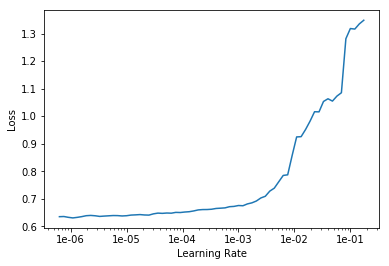

In [30]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 2.0e-5

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(120, max_lr=lr, wd=0.01)

epoch,train_loss,valid_loss,accuracy
1,0.647744,0.560832,0.800000
2,0.642336,0.563320,0.786667
3,0.636642,0.557776,0.800000
4,0.631460,0.553656,0.786667
5,0.628575,0.554631,0.753333
6,0.624284,0.536982,0.740000
7,0.619385,0.552092,0.740000
8,0.614203,0.542687,0.733333
9,0.606767,0.546605,0.740000
10,0.601990,0.544118,0.740000


In [ ]:
learn.save('vgg16like-avgpool-exact-relu')

### Estimate AUC on testing set

In [70]:
np.random.seed(42)

data_test = ImageDataBunch.from_folder(path, train="train", valid="test", valid_pct=None,dl_tfms=None, size=sz, num_workers=4).normalize(imagenet_stats)

In [71]:
data_test.classes, data_test.c, len(data_test.train_ds)

(['melanoma', 'other'], 2, 2800)

In [72]:
learn_inf = Learner(data_test, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [73]:
learn_inf.load('vgg16like-avgpool-exact-relu')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (2800 items)
[Category other, Category other, Category other, Category other, Category other]...
Path: data
x: ImageItemList (2800 items)
[Image (3, 4361, 6602), Image (3, 2016, 3024), Image (3, 768, 1024), Image (3, 768, 1024), Image (3, 768, 1024)]...
Path: data;

Valid: LabelList
y: CategoryList (600 items)
[Category other, Category other, Category other, Category other, Category other]...
Path: data
x: ImageItemList (600 items)
[Image (3, 2000, 3008), Image (3, 4439, 6688), Image (3, 2000, 3008), Image (3, 2848, 4288), Image (3, 2000, 3008)]...
Path: data;

Test: None, model=vgg16Like(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [75]:
preds_test, labels_test = learn_inf.get_preds(ds_type=DatasetType.Valid)

In [78]:
roc_auc_score(labels_test, np.array(preds_test.tolist())[:,1])

0.8883934101325407

### Export to Protocol Buffer file 

In [ ]:
pytorch_model = learn.model
pytorch_model.eval()

export_to_pb(pytorch_model, filename='skincancer_model.pb')